In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

file_path = 'train.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

file_path = 'test.csv'
df_test = pd.read_csv(file_path)

In [17]:
from sklearn.preprocessing import LabelEncoder
topics = df['topic']
#LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(topics)
train_labels.shape,np.unique(train_labels)

((2088,), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [18]:
df_X=pd.DataFrame()
df=df.fillna(' ')
df_X['X_text']=df['content']+' '+df['author']+''+df['hashtag_related 1']+''+df['hashtag_related 2']+''+df['hashtag_related 3']+''+df['hashtag_related 4']+''+df['hashtag_related 5']
df_X['Y']=train_labels
df_X.head()

,X_text,Y
0,hmmmm so like when a country is selected t...,12
1,forest path autumn © copyright 2023 g dan mi...,3
2,democracy in trouble today s cartoon by pares...,10
3,・ namban folding screens ・ 👤 kano domi att...,0
4,still no news on what will happen to jorge lui...,0


In [19]:
topics_test = df_test['topic']
test_labels = label_encoder.fit_transform(topics_test)
test_labels.shape,np.unique(test_labels)

((523,), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [20]:
df_X_test=pd.DataFrame()
df_test=df_test.fillna(' ')
df_X_test['X_text']=df_test['content']+' '+df_test['author']+''+df_test['hashtag_related 1']+''+df_test['hashtag_related 2']+''+df_test['hashtag_related 3']+''+df_test['hashtag_related 4']+''+df_test['hashtag_related 5']
df_X_test['Y']=test_labels
df_X_test.head()

,X_text,Y
0,beauty lifehack save on makeup remover us...,8
1,reuters ukraine says russians intensify bomb...,9
2,the residency imagining robots at waag futurel...,13
3,tal grazzja 🇲🇹 malta 2006 📷shot © bianca...,14
4,green snake on a tree branch photography n...,3


In [21]:
X_train=df_X['X_text']
y_train=df_X['Y']
X_test=df_X_test['X_text']
y_test=df_X_test['Y']
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2088,), (523,), (2088,), (523,))

In [22]:
# 数据准备（这里假设你有一个包含文本和标签的数据集）
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': self.labels[idx]}

# 实例化数据集和数据加载器
train_texts = X_train.tolist()
train_labels = y_train.tolist()

train_dataset = CustomDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 初始化 BERT 模型和令牌化器
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=15)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

# 训练模型
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [24]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    print('kfold',fold)
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Create DataLoader for training and validation data
    train_dataset = CustomDataset(X_train_fold.tolist(),y_train_fold.tolist())
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    val_dataset = CustomDataset(X_val_fold.tolist(),y_val_fold.tolist())
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

    # Initialize your model
    # Training loop

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
            labels = torch.tensor(batch['label']).to(device)

            inputs = {key: val.to(device) for key, val in inputs.items()}

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")


    # # Validation loop
    # model.eval()
    # all_val_preds = []
    # with torch.no_grad():
    #     for inputs, labels in val_loader:
    #         outputs = model(inputs)
    #         _, preds = torch.max(outputs, 1)
    #         all_val_preds.extend(preds.cpu().numpy())

    # val_accuracy = accuracy_score(y_val_fold, all_val_preds)
    # print(f'Fold {fold + 1}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Calculate and print the overall cross-validation accuracy


kfold 0


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.1537866871589902
Epoch 2/3, Loss: 0.11365876858518727
Epoch 3/3, Loss: 0.09275407421177831
kfold 1


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.14317039766017048
Epoch 2/3, Loss: 0.10765716918455116
Epoch 3/3, Loss: 0.0784818804833567
kfold 2


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.07999948659033954
Epoch 2/3, Loss: 0.06746398626944457
Epoch 3/3, Loss: 0.05600232510324354
kfold 3


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.061103652368417416
Epoch 2/3, Loss: 0.052774786359320085
Epoch 3/3, Loss: 0.049006066267945986
kfold 4


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.0496386063022903
Epoch 2/3, Loss: 0.0439404869516348
Epoch 3/3, Loss: 0.042320365120453396
kfold 5


<ipython-input-24-b9a44570ed3f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.044988274173918125
Epoch 2/3, Loss: 0.0397101615063161
Epoch 3/3, Loss: 0.04471730518518765


In [25]:
model.save_pretrained('save/model')


In [26]:
model.eval()
from sklearn.metrics import accuracy_score, f1_score


total_loss, total_acc = 0, 0
predicted_labels, true_labels = [], []

for batch in train_loader:
    inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
    labels = torch.tensor(batch['label']).to(device)

    inputs = {key: val.to(device) for key, val in inputs.items()}

    optimizer.zero_grad()
    outputs = model(**inputs)
    loss = criterion(outputs.logits, labels)
    total_loss += loss.item()

    # 将模型输出转换为类别标签
    _, predicted_label = torch.max(outputs.logits, 1)
    predicted_labels.extend(predicted_label.cpu().numpy())
    true_labels.extend(batch['label'])

# 计算准确率
acc = accuracy_score(true_labels, predicted_labels)
average_loss = total_loss / len(train_loader)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Loss: {average_loss} Accuracy: {acc} f1_score: {f1}")


<ipython-input-26-64b12cd96510>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Loss: 0.02662397742688913 Accuracy: 0.9913793103448276 f1_score: 0.9912257305260445


In [27]:
from sklearn.metrics import classification_report,  confusion_matrix

# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 计算分类报告（包括F1 Score等）
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Accuracy: 0.9913793103448276
Confusion Matrix:
[[109   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 122   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0 124   0   0   0   0   0   0   0   1   0   0   0]
 [  1   0   1   0 106   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0  80   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 131   0   1   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0 123   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0 115   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1 124   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 120   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0 110   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0 111   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0 128]]
Classif

In [28]:
decoded_labels=label_encoder.inverse_transform(range(15))

In [29]:
decoded_labels

array(['Art and Culture', 'Education', 'Entertainment', 'Environment',
       'Fashion', 'Food', 'Health', 'Humor', 'Lifestyle', 'News',
       'Politics', 'Science', 'Sports', 'Technology', 'Travel'],
      dtype=object)

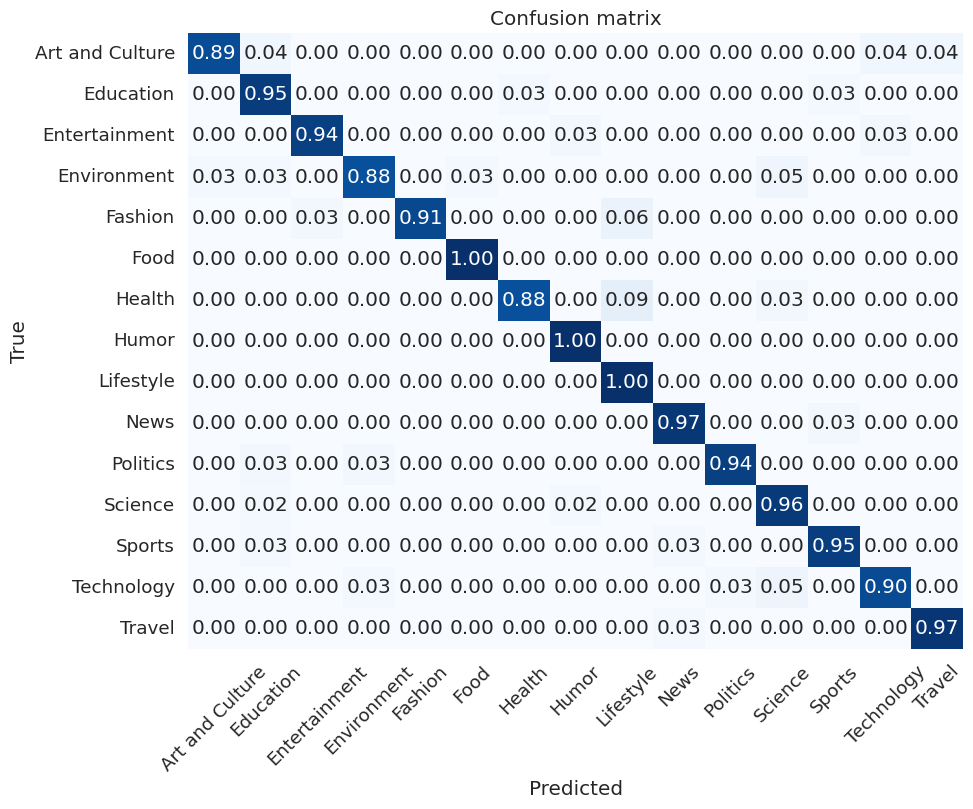

In [34]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Bret CM")
plt.show()

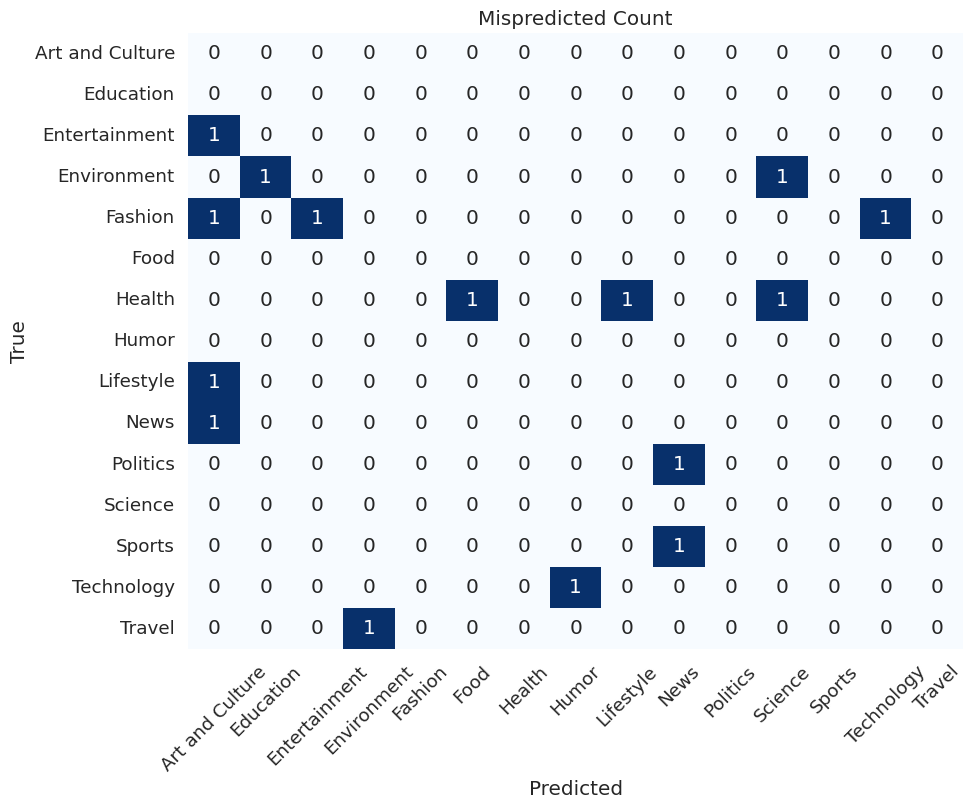

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 示例数据（确保替换为你的实际数据）
conf_matrix = confusion_matrix(true_labels, predicted_labels)
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("Bret Mispredicted")
plt.show()


In [32]:
model.eval()

test_texts = X_test.tolist()
test_labels = y_test.tolist()

test_dataset = CustomDataset(test_texts, test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

total_loss, total_acc = 0, 0
predicted_labels, true_labels = [], []

for batch in test_loader:
    inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
    labels = torch.tensor(batch['label']).to(device)

    inputs = {key: val.to(device) for key, val in inputs.items()}

    optimizer.zero_grad()
    outputs = model(**inputs)
    loss = criterion(outputs.logits, labels)
    total_loss += loss.item()

    # 将模型输出转换为类别标签
    _, predicted_label = torch.max(outputs.logits, 1)
    predicted_labels.extend(predicted_label.cpu().numpy())
    true_labels.extend(batch['label'])

# 计算准确率
acc = accuracy_score(true_labels, predicted_labels)
average_loss = total_loss / len(train_loader)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Test set Loss: {average_loss} Accuracy: {acc} f1_score: {f1}")


<ipython-input-32-983560838e81>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Test set Loss: 0.07701289007204702 Accuracy: 0.9407265774378585 f1_score: 0.9412480110260523


In [ ]:
# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 计算分类报告（包括F1 Score等）
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Accuracy: 0.9426386233269598
Confusion Matrix:
[[27  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  1  0  0  0  0  0  1  0  0]
 [ 1  0 29  0  0  0  0  1  0  0  0  1  0  0  0]
 [ 1  0  0 37  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  1  0 29  0  0  0  2  0  0  0  0  0  0]
 [ 1  0  0  0  0 24  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  2  0  0  1  0  0  0]
 [ 0  0  1  0  0  1  0 34  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 32  0  0  0  0]
 [ 0  1  0  1  0  0  0  1  0  0  0 44  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 38  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  1  2  0 35  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.95      0.95      0.95        40
           2       0.94      0.91      0.92   

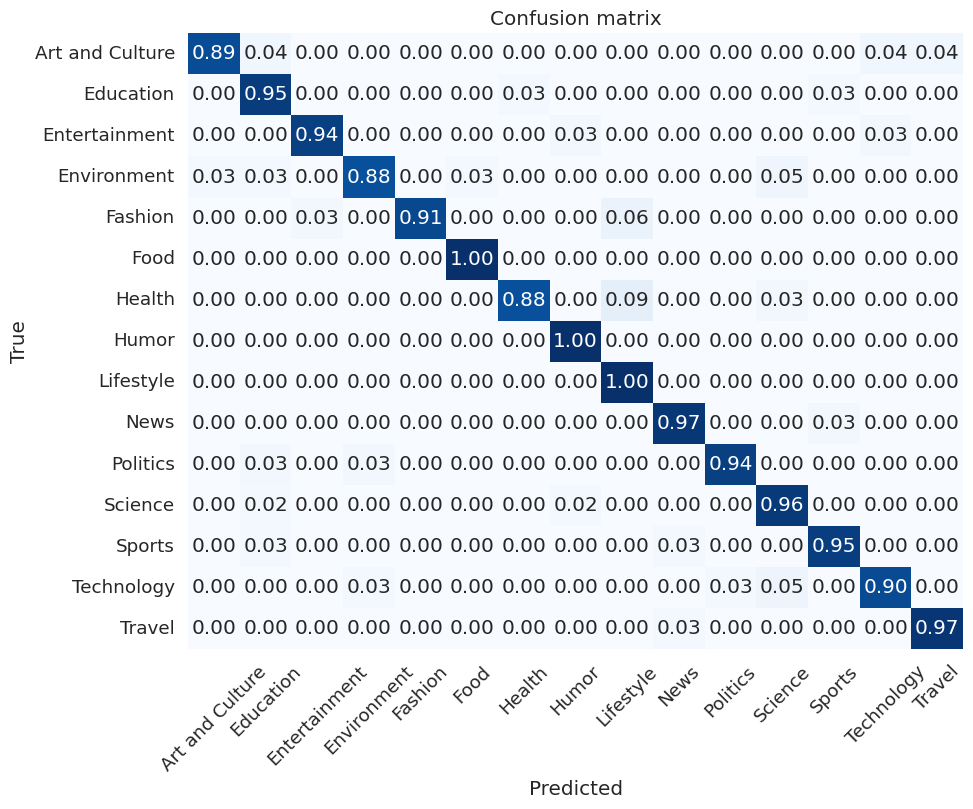

In [33]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Test Bret CM")
plt.show()

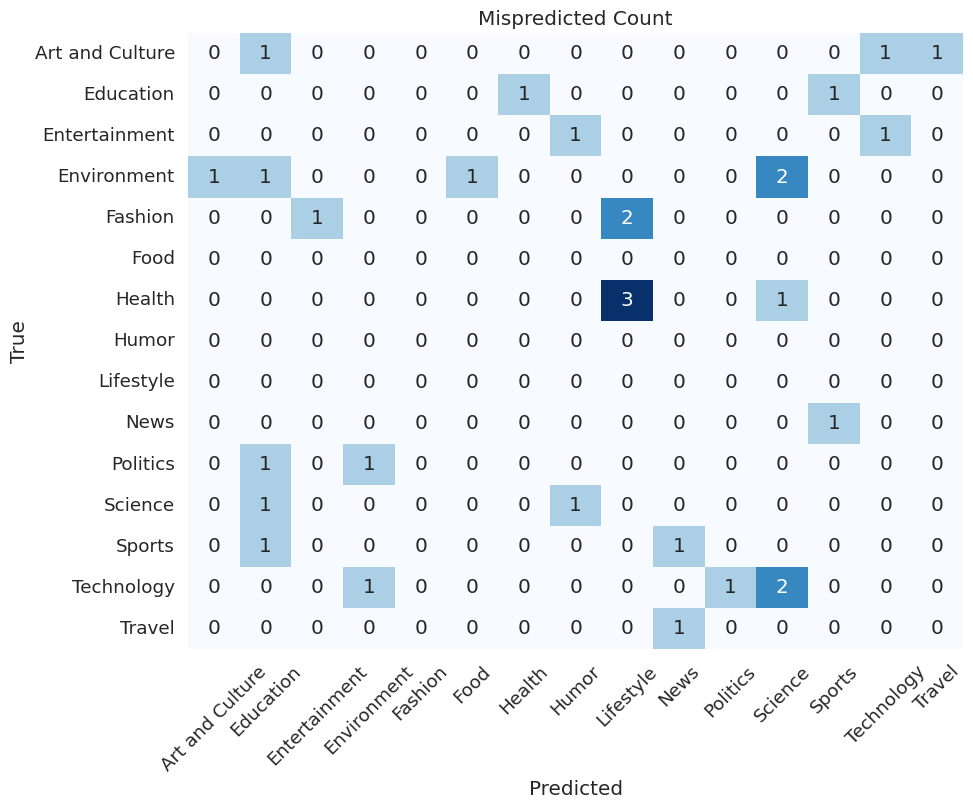

In [35]:
# 示例数据（确保替换为你的实际数据）
conf_matrix = confusion_matrix(true_labels, predicted_labels)
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("Test Bret Mispredicted")
plt.show()